In [46]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import mplhep as hep
from jetnet.datasets import JetNet
from model.refinement import GNN, FCN, NodeFCN, GNN2, NodeFCN2
from model.mpgan.model import MPNet
plt.style.use(hep.style.CMS)

In [47]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [48]:
# model = MPNet(30, 3, output_node_size=3)
# model = GNN()
# model = GNN2()
# model = FCN()
# model = NodeFCN()
# model = NodeFCN2()
# model.load_state_dict(torch.load('refinement/models/MPNet_refinement.pt'))
# model.load_state_dict(torch.load('refinement/models/GNN_refinement.pt'))
# model.load_state_dict(torch.load('refinement/models/GNN2_refinement.pt'))
# model.load_state_dict(torch.load('refinement/models/FCN_refinement.pt'))
# model.load_state_dict(torch.load('refinement/models/NodeFCN_refinement.pt'))
# model.load_state_dict(torch.load('refinement/models/NodeFCN2_refinement.pt'))
# model.cuda();
# count_parameters(model)

In [49]:
np.random.seed(99)
def load_gluon_dataset(dataroot):
    particle_data, jet_data = JetNet.getData(jet_type=["g"], data_dir=dataroot)
    particle_data = particle_data[..., :-1] # toss mask dimension
    dataset_size = 1000
    np.random.shuffle(particle_data)
    particle_data = particle_data[:dataset_size]
    m = particle_data.mean(axis=1).reshape(-1, 1, 3)
    s = particle_data.std(axis=1).reshape(-1, 1, 3)
    return particle_data * s + m

In [50]:
samples = torch.load('/diffusionvol/experiments/test_generation/pvd_gluons_bkup/syn/samples.pth')
ref = torch.load('/diffusionvol/experiments/test_generation/pvd_gluons_bkup/syn/ref.pth')
# ref = load_gluon_dataset('/diffusionvol/data/')
samples = samples.numpy()
# ref = ref.numpy()

In [51]:
# use cell for refinement network

# _samples = []
# bs = 256
# for i in range(0, len(samples), bs):
#     _samples.append(model(torch.tensor(samples[i:i+bs]).cuda()))
# _samples = torch.cat(_samples)
# _samples.shape
# samples = _samples.detach().cpu().numpy()

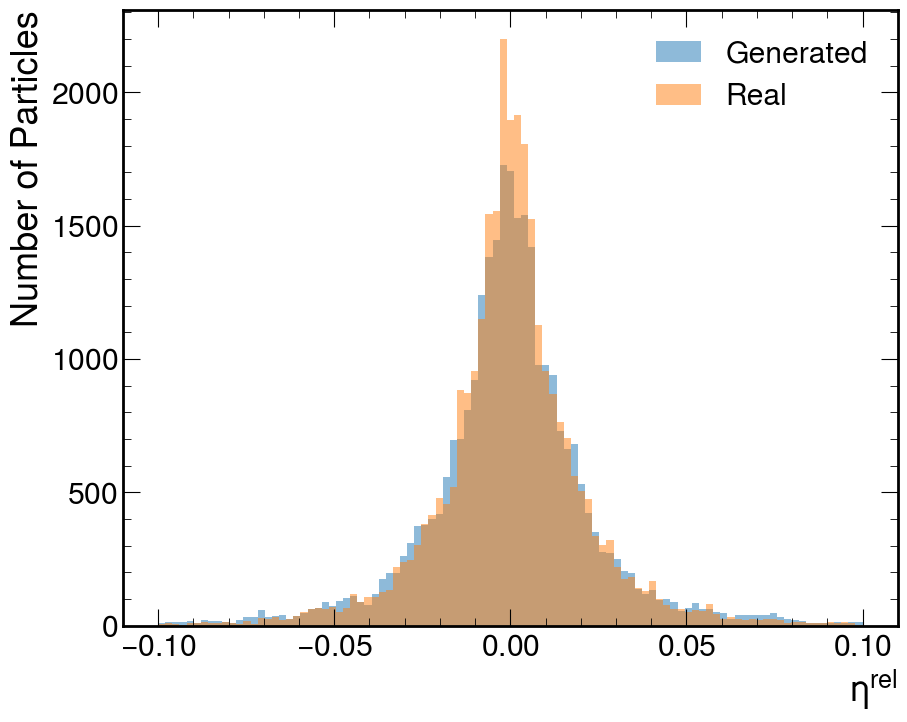

In [52]:
plt.figure(figsize=(10,8))
plt.hist(samples[..., 0].flatten(), bins=np.linspace(-0.1, 0.1, 100), alpha=0.5, label='Generated');
plt.hist(ref[..., 0].flatten(), bins=np.linspace(-0.1, 0.1, 100), alpha=0.5, label='Real');
plt.legend()
plt.ticklabel_format(useMathText=True)
plt.xlabel("$\eta^{rel}$")
plt.ylabel('Number of Particles')
plt.savefig('eta.png')
plt.show()

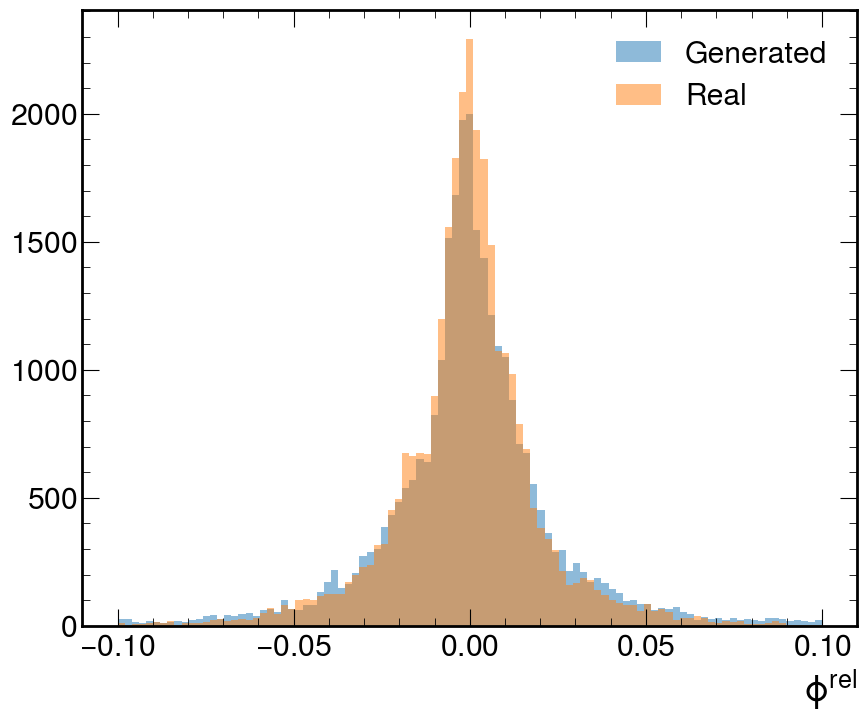

In [53]:
plt.style.use(hep.style.CMS)
plt.figure(figsize=(10,8))
plt.hist(samples[..., 1].flatten(), bins=np.linspace(-0.1, 0.1, 100), alpha=0.5, label='Generated');
plt.hist(ref[..., 1].flatten(), bins=np.linspace(-0.1, 0.1, 100), alpha=0.5, label='Real');
plt.legend()
plt.ticklabel_format(useMathText=True)
plt.xlabel("$\phi^{rel}$")
plt.savefig('phi.png')
plt.show()

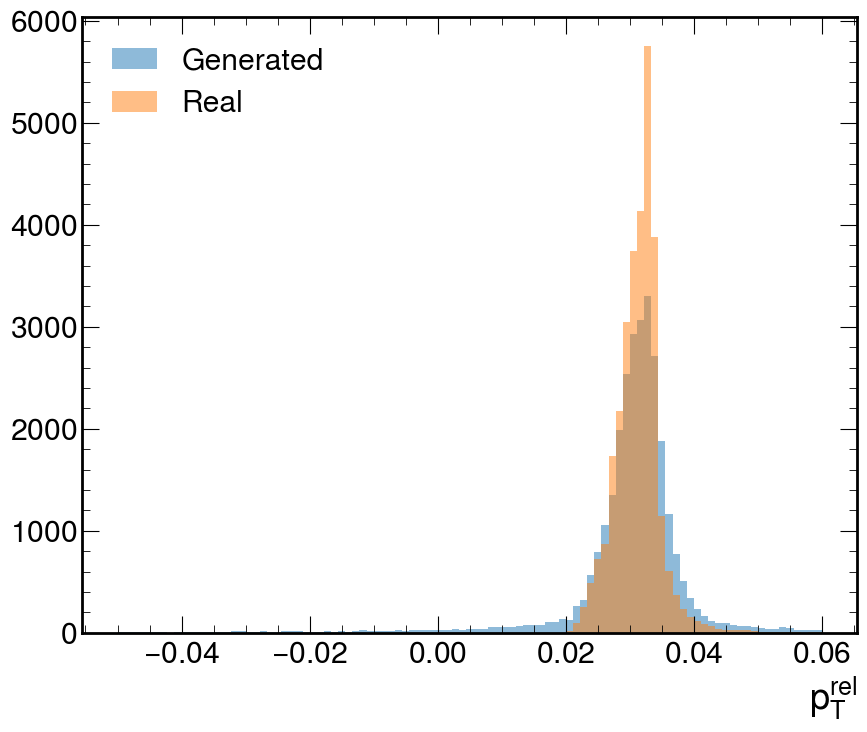

In [54]:
plt.style.use(hep.style.CMS)
plt.figure(figsize=(10,8))
plt.hist(samples[..., 2].flatten(), bins=np.linspace(-0.05, 0.06, 100), alpha=0.5, label='Generated');
plt.hist(ref[..., 2].flatten(), bins=np.linspace(-0.05, 0.06, 100), alpha=0.5, label='Real');
plt.legend()
plt.ticklabel_format(useMathText=True)
plt.xlabel("$p_T^{rel}$")
plt.savefig('pt.png')
plt.show()

In [55]:
from jetnet import evaluation

In [56]:
samples_pt_pos = samples
samples_pt_pos[..., -1] = samples_pt_pos[..., -1].clip(min=0)

In [57]:
cov, mmd = evaluation.cov_mmd(samples_pt_pos, ref)

Calculating cov and mmd over 10 batches: 100%|██████████| 10/10 [00:13<00:00,  1.38s/it]


In [58]:
print(f'COV: {cov}')
print(f'MMD: {mmd}')

COV: 0.5029999999999999
MMD: 0.07048081257071907


In [59]:
w1efpm, w1efpstd = evaluation.w1efp(
    samples,
    ref,
    use_particle_masses=False,
    average_over_efps=True,
    return_std=True
)
print(w1efpm, w1efpstd)

0.0819706104219639 0.029054301912374045


In [60]:
w1mm, w1mstd = evaluation.w1m(
    samples,
    ref,
    return_std=True
)
print(w1mm, w1mstd)

0.0275960228870716 0.0013814666525045806


In [61]:
w1pm, w1pstd = evaluation.w1p(
    samples,
    ref,
    return_std=True
)
print(w1pm, w1pstd)


0.008037621579293781 0.00040113228477303047


In [62]:
fpd = evaluation.fpnd(samples, jet_type='g')

Running ParticleNet: 100%|██████████| 63/63 [00:00<00:00, 191.30it/s]


In [63]:
fpd

149.04723675339105